In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve


In [3]:
data = load_breast_cancer()
X = data.data
y = data.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [5]:
pipe_lr = make_pipeline(StandardScaler(), PCA(), LogisticRegression(max_iter=160))

In [6]:
import scipy.stats
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy

param_range = scipy.stats.loguniform(0.0001, 1000.0)

param_grid = {
    'pca__n_components' : [2, 5, 10, 15],
    'logisticregression__C' : param_range,
}

# hs = HalvingRandomSearchCV(estimator=pipe_lr, param_distributions=param_grid, factor=1.5, n_candidates='exhaust', resource='n_samples', random_state=1, n_jobs=-1)
rs = RandomizedSearchCV(estimator=pipe_lr, param_distributions=param_grid, n_iter=20, cv=10, scoring='accuracy', n_jobs=-1, refit=True)

In [7]:
# hs = hs.fit(X_train, y_train)
rs = rs.fit(X_train, y_train)
best_lr = rs.best_estimator_

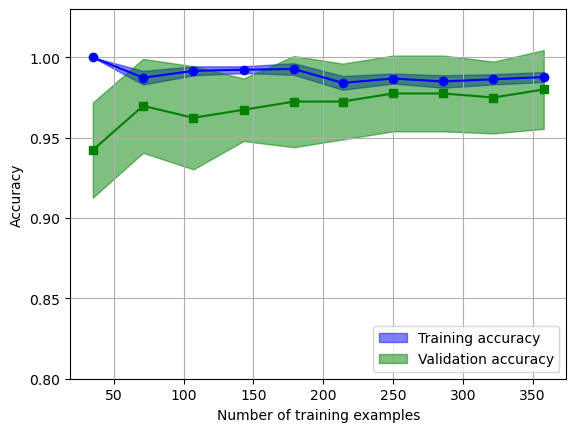

In [8]:
train_size_abs, train_scores, test_scores = learning_curve(estimator=best_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_size_abs, train_mean, marker='o', color='blue')
plt.fill_between(train_size_abs, train_mean + train_std, train_mean - train_std, color='blue', alpha=0.5, label='Training accuracy')

plt.plot(train_size_abs, test_mean, marker='s', color='green')
plt.fill_between(train_size_abs, test_mean + test_std, test_mean - test_std, color='green', alpha=0.5, label='Validation accuracy')


plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

In [9]:
evaluation = cross_val_score(estimator=best_lr, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1)
evaluation.mean()

0.9774367088607594

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = best_lr.fit(X_train, y_train).predict(X_test)
confmat = confusion_matrix(y_pred=y_pred, y_true=y_test)
confmat

array([[ 59,   5],
       [  2, 105]], dtype=int64)

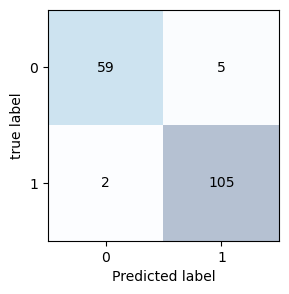

In [11]:
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        plt.text(x=j, y=i, s=confmat[i, j],
                 va='center', ha='center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('true label')
plt.show()

In [12]:
from sklearn.metrics import classification_report

classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, digits=2)

{'0': {'precision': 0.9672131147540983,
  'recall': 0.921875,
  'f1-score': 0.944,
  'support': 64.0},
 '1': {'precision': 0.9545454545454546,
  'recall': 0.9813084112149533,
  'f1-score': 0.967741935483871,
  'support': 107.0},
 'accuracy': 0.9590643274853801,
 'macro avg': {'precision': 0.9608792846497765,
  'recall': 0.9515917056074766,
  'f1-score': 0.9558709677419355,
  'support': 171.0},
 'weighted avg': {'precision': 0.9592865671381634,
  'recall': 0.9590643274853801,
  'f1-score': 0.9588560648934163,
  'support': 171.0}}

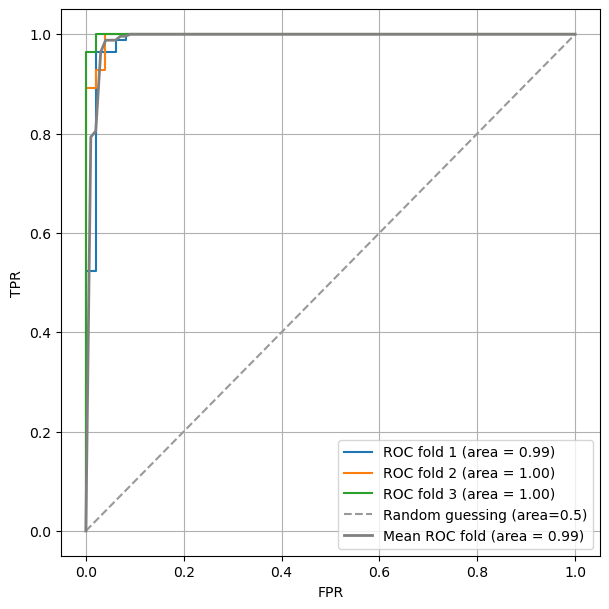

In [54]:
from sklearn.metrics import roc_curve, auc


cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fid = plt.figure(figsize=(6,6))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = best_lr.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, threshold = roc_curve(y_true=y_train[test], y_score=probas[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC fold (area = {mean_auc:.2f})', lw=2, color='gray')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.show()